In [1]:
import numpy as np

from time import time

import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

In [2]:
import rustworkx as rx

from qiskit_nature.problems.second_quantization.lattice import Lattice

# Custom Heisenberg couplings
import sys
sys.path.append(r'.')  # may be needed if running notebook on a cloud service
#from qiskit_nature.second_q.hamiltonians import HeisenbergModel
from heisenberg_model import HeisenbergModel

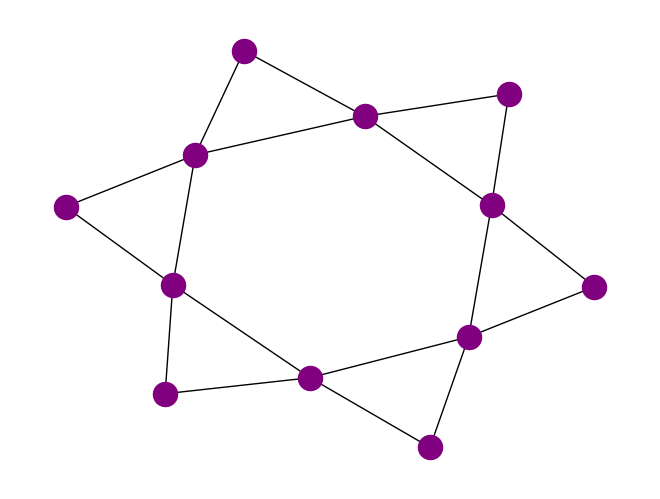

In [3]:
# Kagome unit cell
num_sites = 12
# Edge weight
t = 1.0

# Generate graph of kagome unit cell
# Start by defining all the edges
graph = rx.PyGraph(multigraph=False)
graph.add_nodes_from(range(num_sites))
edge_list = [
    (0, 1, t),
    (1, 2, t),
    (2, 3, t),
    (3, 4, t),
    (4, 5, t),
    (5, 0, t),
    (0, 6, t),
    (1, 6, t),
    (1, 7, t),
    (2, 7, t),
    (2, 8, t),
    (3, 8, t),
    (3, 9, t),
    (4, 9, t),
    (4, 10, t),
    (5, 10, t),
    (5, 11, t),
    (0, 11, t),
]
# Generate graph from the list of edges
graph.add_edges_from(edge_list)

# Make a Lattice from graph
kagome_unit_cell = Lattice(graph)

# Draw Lattice
kagome_unit_cell.draw(style={'node_color':'purple'})
# plt.savefig('kagome_unit_cell.png')
plt.show()

In [4]:
from qiskit_nature.mappers.second_quantization import LogarithmicMapper

In [5]:
# Build Hamiltonian from graph edges
heis = HeisenbergModel.uniform_parameters(
    lattice=kagome_unit_cell,
    uniform_interaction=1.0,  # same spin-spin interaction weight as used in graph
    uniform_onsite_potential=0.0,  # No singe site external field
)

# The Lattice needs an explicit mapping to the qubit states.
# We map 1 qubit for 1 spin-1/2 particle using the LogarithmicMapper
log_mapper = LogarithmicMapper()
# Multiply by factor of 4 to account for (1/2)^2 terms from spin operators in the HeisenbergModel
ham = 4 * log_mapper.map(heis.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect.
# There are 18 edges and 3 terms per edge (XX, YY, and ZZ),
# so there should be 54 equally weighted terms.
ham

PauliSumOp(SparsePauliOp(['ZIIIIIZIIIII', 'IZIIIIZIIIII', 'IZIIIIIZIIII', 'IIZIIIIZIIII', 'IIIIIIZZIIII', 'IIZIIIIIZIII', 'IIIZIIIIZIII', 'IIIIIIIZZIII', 'IIIZIIIIIZII', 'IIIIZIIIIZII', 'IIIIIIIIZZII', 'IIIIZIIIIIZI', 'IIIIIZIIIIZI', 'IIIIIIIIIZZI', 'ZIIIIIIIIIIZ', 'IIIIIZIIIIIZ', 'IIIIIIZIIIIZ', 'IIIIIIIIIIZZ', 'YIIIIIYIIIII', 'IYIIIIYIIIII', 'IYIIIIIYIIII', 'IIYIIIIYIIII', 'IIIIIIYYIIII', 'IIYIIIIIYIII', 'IIIYIIIIYIII', 'IIIIIIIYYIII', 'IIIYIIIIIYII', 'IIIIYIIIIYII', 'IIIIIIIIYYII', 'IIIIYIIIIIYI', 'IIIIIYIIIIYI', 'IIIIIIIIIYYI', 'YIIIIIIIIIIY', 'IIIIIYIIIIIY', 'IIIIIIYIIIIY', 'IIIIIIIIIIYY', 'XIIIIIXIIIII', 'IXIIIIXIIIII', 'IXIIIIIXIIII', 'IIXIIIIXIIII', 'IIIIIIXXIIII', 'IIXIIIIIXIII', 'IIIXIIIIXIII', 'IIIIIIIXXIII', 'IIIXIIIIIXII', 'IIIIXIIIIXII', 'IIIIIIIIXXII', 'IIIIXIIIIIXI', 'IIIIIXIIIIXI', 'IIIIIIIIIXXI', 'XIIIIIIIIIIX', 'IIIIIXIIIIIX', 'IIIIIIXIIIIX', 'IIIIIIIIIIXX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j

In [6]:
from qiskit.algorithms import NumPyEigensolver

# find the first three (k=3) eigenvalues
exact_solver = NumPyEigensolver(k=3)
exact_result = exact_solver.compute_eigenvalues(ham)
print(exact_result.eigenvalues)

# Save ground state energy for later
gs_energy = np.round(exact_result.eigenvalues[0], 4)

[-18.         -18.         -16.96132284]


In [7]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter

from qiskit import IBMQ

In [8]:
# Doc for loading IBMQ account https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq#the-account
# IBMQ.save_account(TOKEN)
IBMQ.load_account() # Load account from disk
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')

# Real backend; needed for transpilation later on
guadalupe = provider.get_backend("ibmq_guadalupe")

# Get fake backend if you like
# from qiskit.providers.fake_provider import FakeGuadalupe

# Noisy simulator backend
# noisy_sim = FakeGuadalupe()

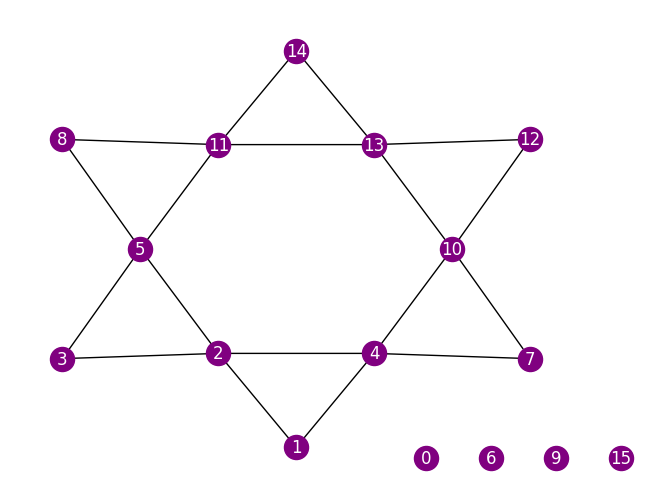

In [9]:
# Kagome unit cell
num_qubits = 16
# Edge weight
t = 1.0

# Generate graph of kagome unit cell
# Start by defining all the edges
graph_16 = rx.PyGraph(multigraph=False)
graph_16.add_nodes_from(range(num_qubits))
edge_list = [
    (1, 2, t),
    (2, 3, t),
    (3, 5, t),
    (5, 8, t),
    (8, 11, t),
    (11, 14, t),
    (14, 13, t),
    (13, 12, t),
    (12, 10, t),
    (10, 7, t),
    (7, 4, t),
    (4, 1, t),
    (4, 2, t),
    (2, 5, t),
    (5, 11, t),
    (11, 13, t),
    (13, 10, t),
    (10, 4, t),
]
# Generate graph from the list of edges
graph_16.add_edges_from(edge_list)

# Make a Lattice from graph
kagome_unit_cell_16 = Lattice(graph_16)

# Draw Lattice and include labels to check we exclude the right spins
# Specify node locations for better visualizations
kagome_pos = {0:[1,-1], 6:[1.5,-1], 9:[2,-1], 15:[2.5,-1], 
              1:[0,-0.8], 2:[-0.6,1], 4:[0.6,1], 10:[1.2,3], 
              13:[0.6,5], 11:[-0.6,5], 5:[-1.2,3], 3:[-1.8,0.9], 
              8:[-1.8,5.1], 14:[0,6.8], 7:[1.8,0.9], 12:[1.8,5.1]}
kagome_unit_cell_16.draw(style={'with_labels':True, 'font_color':'white', 'node_color':'purple', 'pos':kagome_pos})
plt.show()

In [10]:
# Build Hamiltonian from graph edges
heis_16 = HeisenbergModel.uniform_parameters(
    lattice=kagome_unit_cell_16,
    uniform_interaction=t,
    uniform_onsite_potential=0.0,  # No singe site external field
)

# Map from SpinOp to qubits just as before.
log_mapper = LogarithmicMapper()
ham_16 = 4 * log_mapper.map(heis_16.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect:
# 18 ZZ, 18 YY, and 18 XX terms over 16 qubits instead of over 12 qubits
ham_16

PauliSumOp(SparsePauliOp(['IZZIIIIIIIIIIIII', 'IIZZIIIIIIIIIIII', 'IZIIZIIIIIIIIIII', 'IIZIZIIIIIIIIIII', 'IIZIIZIIIIIIIIII', 'IIIZIZIIIIIIIIII', 'IIIIZIIZIIIIIIII', 'IIIIIZIIZIIIIIII', 'IIIIZIIIIIZIIIII', 'IIIIIIIZIIZIIIII', 'IIIIIZIIIIIZIIII', 'IIIIIIIIZIIZIIII', 'IIIIIIIIIIZIZIII', 'IIIIIIIIIIZIIZII', 'IIIIIIIIIIIZIZII', 'IIIIIIIIIIIIZZII', 'IIIIIIIIIIIZIIZI', 'IIIIIIIIIIIIIZZI', 'IYYIIIIIIIIIIIII', 'IIYYIIIIIIIIIIII', 'IYIIYIIIIIIIIIII', 'IIYIYIIIIIIIIIII', 'IIYIIYIIIIIIIIII', 'IIIYIYIIIIIIIIII', 'IIIIYIIYIIIIIIII', 'IIIIIYIIYIIIIIII', 'IIIIYIIIIIYIIIII', 'IIIIIIIYIIYIIIII', 'IIIIIYIIIIIYIIII', 'IIIIIIIIYIIYIIII', 'IIIIIIIIIIYIYIII', 'IIIIIIIIIIYIIYII', 'IIIIIIIIIIIYIYII', 'IIIIIIIIIIIIYYII', 'IIIIIIIIIIIYIIYI', 'IIIIIIIIIIIIIYYI', 'IXXIIIIIIIIIIIII', 'IIXXIIIIIIIIIIII', 'IXIIXIIIIIIIIIII', 'IIXIXIIIIIIIIIII', 'IIXIIXIIIIIIIIII', 'IIIXIXIIIIIIIIII', 'IIIIXIIXIIIIIIII', 'IIIIIXIIXIIIIIII', 'IIIIXIIIIIXIIIII', 'IIIIIIIXIIXIIIII', 'IIIIIXIIIIIXIIII', 'IIIIIIIIXIIXIIII', 'IIIIIIIIIIXIX

In [11]:
from qiskit.circuit.library import EfficientSU2
from qiskit.circuit.library import RealAmplitudes

In [12]:
# Construct ansatz from qiskit circuit library functions
# See docs for full details
ansatz = EfficientSU2(12, entanglement='linear', reps=3, skip_final_rotation_layer=True).decompose()
ansatz.draw(fold=300)

┌──────────┐┌───────────┐     ┌───────────┐┌───────────┐                          ┌───────────┐┌───────────┐                                                                                                                                            
 q_0: ─┤ Ry(θ[0]) ├┤ Rz(θ[12]) ├──■──┤ Ry(θ[24]) ├┤ Rz(θ[36]) ├───────────────────■──────┤ Ry(θ[48]) ├┤ Rz(θ[60]) ├───────────────────■────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       ├──────────┤├───────────┤┌─┴─┐└───────────┘├───────────┤┌───────────┐    ┌─┴─┐    └───────────┘├───────────┤┌───────────┐    ┌─┴─┐                                                                                                                      
 q_1: ─┤ Ry(θ[1]) ├┤ Rz(θ[13]) ├┤ X ├──────■──────┤ Ry(θ[25]) ├┤ Rz(θ[37]) ├────┤ X ├──────────■──────┤ Ry(θ[49]) ├┤ Rz(θ[61]) ├────┤ X ├──────────■───────────────────────────────────────────────────────────────────────────────────────────────────────────
       ├──────────┤├───────────┤└───┘    ┌─┴─┐    └───────────┘├───────────┤┌───┴───┴───┐    ┌─┴─┐    └───────────┘├───────────┤┌───┴───┴───┐    ┌─┴─┐                                                                                                         
 q_2: ─┤ Ry(θ[2]) ├┤ Rz(θ[14]) ├─────────┤ X ├──────────■──────┤ Ry(θ[26]) ├┤ Rz(θ[38]) ├────┤ X ├──────────■──────┤ Ry(θ[50]) ├┤ Rz(θ[62]) ├────┤ X ├──────────■──────────────────────────────────────────────────────────────────────────────────────────────
       ├──────────┤├───────────┤         └───┘        ┌─┴─┐    └───────────┘├───────────┤┌───┴───┴───┐    ┌─┴─┐    └───────────┘├───────────┤┌───┴───┴───┐    ┌─┴─┐                                                                                            
 q_3: ─┤ Ry(θ[3]) ├┤ Rz(θ[15]) ├──────────────────────┤ X ├──────────■──────┤ Ry(θ[27]) ├┤ Rz(θ[39]) ├────┤ X ├──────────■──────┤ Ry(θ[51]) ├┤ Rz(θ[63]) ├────┤ X ├──────────■─────────────────────────────────────────────────────────────────────────────────
       ├──────────┤├───────────┤                      └───┘        ┌─┴─┐    └───────────┘├───────────┤┌───┴───┴───┐    ┌─┴─┐    └───────────┘├───────────┤┌───┴───┴───┐    ┌─┴─┐                                                                               
 q_4: ─┤ Ry(θ[4]) ├┤ Rz(θ[16]) ├───────────────────────────────────┤ X ├──────────■──────┤ Ry(θ[28]) ├┤ Rz(θ[40]) ├────┤ X ├──────────■──────┤ Ry(θ[52]) ├┤ Rz(θ[64]) ├────┤ X ├──────────■────────────────────────────────────────────────────────────────────
       ├──────────┤├───────────┤                                   └───┘        ┌─┴─┐    └───────────┘├───────────┤┌───┴───┴───┐    ┌─┴─┐    └───────────┘├───────────┤┌───┴───┴───┐    ┌─┴─┐                                                                  
 q_5: ─┤ Ry(θ[5]) ├┤ Rz(θ[17]) ├────────────────────────────────────────────────┤ X ├──────────■──────┤ Ry(θ[29]) ├┤ Rz(θ[41]) ├────┤ X ├──────────■──────┤ Ry(θ[53]) ├┤ Rz(θ[65]) ├────┤ X ├──────────■───────────────────────────────────────────────────────
       ├──────────┤├───────────┤                                                └───┘        ┌─┴─┐    └───────────┘├───────────┤┌───┴───┴───┐    ┌─┴─┐    └───────────┘├───────────┤┌───┴───┴───┐    ┌─┴─┐                                                     
 q_6: ─┤ Ry(θ[6]) ├┤ Rz(θ[18]) ├─────────────────────────────────────────────────────────────┤ X ├──────────■──────┤ Ry(θ[30]) ├┤ Rz(θ[42]) ├────┤ X ├──────────■──────┤ Ry(θ[54]) ├┤ Rz(θ[66]) ├────┤ X ├──────────■──────────────────────────────────────────
       ├──────────┤├───────────┤                                                             └───┘        ┌─┴─┐    └───────────┘├───────────┤┌───┴───┴───┐    ┌─┴─┐    └───────────┘├───────────┤┌───┴───┴───┐    ┌─┴─┐                                        
 q_7: ─┤ Ry(θ[7]) ├┤ Rz(θ[19]) ├──────────────────────────────────────────────────────────────────────────┤ X ├──────────■──────┤ Ry(θ[31]) ├┤ Rz(θ[43]) ├────┤ X ├────

In [100]:
# Build a custom ansatz from scratch
ansatz_custom = QuantumCircuit(12)
# build initial state
ansatz_custom.x(range(0, 12, 2))
ansatz_custom.cx(range(0, 11, 2), range(1, 12, 2))
# First layer
j = 0
for i in range(12):
    ansatz_custom.rz(Parameter('θ_' + str(j)), i)
    j += 1
    ansatz_custom.ry(Parameter('θ_' + str(j)), i)
    j += 1
ansatz_custom.cx(range(0, 11), range(1, 12))
ansatz_custom.draw(fold=250)

┌───┐     ┌─────────┐ ┌─────────┐                                                        
 q_0: ┤ X ├──■──┤ Rz(θ_0) ├─┤ Ry(θ_1) ├───■────────────────────────────────────────────────────
      └───┘┌─┴─┐├─────────┤ ├─────────┤ ┌─┴─┐                                                  
 q_1: ─────┤ X ├┤ Rz(θ_2) ├─┤ Ry(θ_3) ├─┤ X ├──■───────────────────────────────────────────────
      ┌───┐└───┘├─────────┤ ├─────────┤ └───┘┌─┴─┐                                             
 q_2: ┤ X ├──■──┤ Rz(θ_4) ├─┤ Ry(θ_5) ├──────┤ X ├──■──────────────────────────────────────────
      └───┘┌─┴─┐├─────────┤ ├─────────┤      └───┘┌─┴─┐                                        
 q_3: ─────┤ X ├┤ Rz(θ_6) ├─┤ Ry(θ_7) ├───────────┤ X ├──■─────────────────────────────────────
      ┌───┐└───┘├─────────┤ ├─────────┤           └───┘┌─┴─┐                                   
 q_4: ┤ X ├──■──┤ Rz(θ_8) ├─┤ Ry(θ_9) ├────────────────┤ X ├──■────────────────────────────────
      └───┘┌─┴─┐├─────────┴┐├─────────┴┐               └───┘┌─┴─┐                              
 q_5: ─────┤ X ├┤ Rz(θ_10) ├┤ Ry(θ_11) ├────────────────────┤ X ├──■───────────────────────────
      ┌───┐└───┘├──────────┤├──────────┤                    └───┘┌─┴─┐                         
 q_6: ┤ X ├──■──┤ Rz(θ_12) ├┤ Ry(θ_13) ├─────────────────────────┤ X ├──■──────────────────────
      └───┘┌─┴─┐├──────────┤├──────────┤                         └───┘┌─┴─┐                    
 q_7: ─────┤ X ├┤ Rz(θ_14) ├┤ Ry(θ_15) ├──────────────────────────────┤ X ├──■─────────────────
      ┌───┐└───┘├──────────┤├──────────┤                              └───┘┌─┴─┐               
 q_8: ┤ X ├──■──┤ Rz(θ_16) ├┤ Ry(θ_17) ├───────────────────────────────────┤ X ├──■────────────
      └───┘┌─┴─┐├──────────┤├──────────┤                                   └───┘┌─┴─┐          
 q_9: ─────┤ X ├┤ Rz(θ_18) ├┤ Ry(θ_19) ├────────────────────────────────────────┤ X ├──■───────
      ┌───┐└───┘├──────────┤├──────────┤                                        └───┘┌─┴─┐     
q_10: ┤ X ├──■──┤ Rz(θ_20) ├┤ Ry(θ_21) ├─────────────────────────────────────────────┤ X ├──■──
      └───┘┌─┴─┐├──────────┤├──────────┤                                             └───┘┌─┴─┐
q_11: ─────┤ X ├┤ Rz(θ_22) ├┤ Ry(θ_23) ├──────────────────────────────────────────────────┤ X ├
           └───┘└──────────┘└──────────┘                                                  └───┘

In [101]:
# Force anstaz to be applied to qubits in the heavy hex.
# Avoid the outer qubits 0, 6, 9, and 15 which we accounted for in the lattice definition.
q_layout = [1, 2, 3, 5, 8, 11, 14, 13, 12, 10, 7, 4]
ansatz_opt = transpile(ansatz_custom, backend=guadalupe, initial_layout=q_layout)

print('number and type of gates in the cirucit:', ansatz_opt.count_ops())
print('number of parameters in the circuit:', ansatz_opt.num_parameters)
ansatz_opt.draw(fold=300)

number and type of gates in the cirucit: OrderedDict([('rz', 36), ('sx', 24), ('cx', 17), ('x', 6)])
number of parameters in the circuit: 24


ancilla_0 -> 0 ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                ┌───┐     ┌─────────┐    ┌────┐   ┌─────────────┐      ┌────┐     ┌────────┐                                                            
       q_0 -> 1 ┤ X ├──■──┤ Rz(θ_0) ├────┤ √X ├───┤ Rz(θ_1 + π) ├──────┤ √X ├─────┤ Rz(3π) ├────■───────────────────────────────────────────────────────
                └───┘┌─┴─┐├─────────┤    ├────┤   ├─────────────┤      ├────┤     ├────────┤  ┌─┴─┐                                                     
       q_1 -> 2 ─────┤ X ├┤ Rz(θ_2) ├────┤ √X ├───┤ Rz(θ_3 + π) ├──────┤ √X ├─────┤ Rz(3π) ├──┤ X ├─────■───────────────────────────────────────────────
                ┌───┐└───┘├─────────┤    ├────┤   ├─────────────┤      ├────┤     ├────────┤  └───┘   ┌─┴─┐                                             
       q_2 -> 3 ┤ X ├──■──┤ Rz(θ_4) ├────┤ √X ├───┤ Rz(θ_5 + π) ├──────┤ √X ├─────┤ Rz(3π) ├──────────┤ X ├──■──────────────────────────────────────────
                └───┘  │  └──┬───┬──┘ ┌──┴────┴──┐└────┬────┬───┘ ┌────┴────┴────┐└─┬────┬─┘┌────────┐└───┘  │                                     ┌───┐
      q_11 -> 4 ───────┼─────┤ X ├────┤ Rz(θ_22) ├─────┤ √X ├─────┤ Rz(θ_23 + π) ├──┤ √X ├──┤ Rz(3π) ├───────┼─────────────────────────────────────┤ X ├
                     ┌─┴─┐   └─┬─┘    ├─────────┬┘     ├────┤     ├─────────────┬┘  ├────┤  ├────────┤     ┌─┴─┐                                   └─┬─┘
       q_3 -> 5 ─────┤ X ├─────┼──────┤ Rz(θ_6) ├──────┤ √X ├─────┤ Rz(θ_7 + π) ├───┤ √X ├──┤ Rz(3π) ├─────┤ X ├──■──────────────────────────────────┼──
                     └───┘     │      └─────────┘      └────┘     └─────────────┘   └────┘  └────────┘     └───┘  │                                  │  
 ancilla_1 -> 6 ───────────────┼──────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────┼──
                ┌───┐          │      ┌──────────┐     ┌────┐     ┌──────────────┐  ┌────┐  ┌────────┐            │                           ┌───┐  │  
      q_10 -> 7 ┤ X ├──────────■──────┤ Rz(θ_20) ├─────┤ √X ├─────┤ Rz(θ_21 + π) ├──┤ √X ├──┤ Rz(3π) ├────────────┼───────────────────────────┤ X ├──■──
                ├───┤     ┌─────────┐ └──┬────┬──┘┌────┴────┴───┐ └────┬────┬────┘┌─┴────┴─┐└────────┘          ┌─┴─┐                         └─┬─┘     
       q_4 -> 8 ┤ X ├──■──┤ Rz(θ_8) ├────┤ √X ├───┤ Rz(θ_9 + π) ├──────┤ √X ├─────┤ Rz(3π) ├────────────────────┤ X ├──■────────────────────────┼───────
                └───┘  │  └─────────┘    └────┘   └─────────────┘      └────┘     └────────┘                    └───┘  │                        │       
 ancilla_2 -> 9 ───────┼───────────────────────────────────────────────────────────────────────────────────────────────┼────────────────────────┼───────
                       │     ┌───┐    ┌──────────┐     ┌────┐     ┌──────────────┐  ┌────┐  ┌────────┐                 │                 ┌───┐  │       
      q_9 -> 10 ───────┼─────┤ X ├────┤ Rz(θ_18) ├─────┤ √X ├─────┤ Rz(θ_19 + π) ├──┤ √X ├──┤ Rz(3π) ├─────────────────┼─────────────────┤ X ├──■───────
                     ┌─┴─┐   └─┬─┘    ├──────────┤     ├────┤     ├──────────────┤  ├────┤  ├────────┤               ┌─┴─┐               └─┬─┘          
      q_5 -> 11 ─────┤ X ├─────┼──────┤ Rz(θ_10) ├─────┤ √X ├─────┤ Rz(θ_11 + π) ├──┤ √X ├──┤ Rz(3π) ├───────────────┤ X ├──■──────────────┼────────────
                ┌───┐└───┘     │      ├──────────┤     ├────┤     ├──────────────┤  ├────┤  ├────────┤               └───┘  │       ┌───┐  │            
      q_8 -> 12 ┤ X ├──────────■──────┤ Rz(θ_16) ├─────┤ √X ├─────┤ Rz(θ_17 + π) ├──┤ √X ├──┤ Rz(3π) ├──────────────────────┼───────┤ X ├──■────────────
                └───┘┌───┐┌──────────┐└──┬────┬──┘┌────┴────┴────┐└────┬────┬────┘┌─┴────┴─┐└────────┘                      │  ┌───┐└─┬─┘               
      q_7 -> 13 ─────┤ 

In [102]:
from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA(maxiter=75)

In [112]:
from qiskit.algorithms import MinimumEigensolver, VQEResult

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x])
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            # Save result information using callback function
            if self._callback is not None:
                self._callback(value)
            return value
            
        # Select an initial point for the ansatzs' parameters
        x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        #x0 = 0* np.random.rand(self._circuit.num_parameters)
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

In [113]:
# Define a simple callback function
intermediate_info = []
def callback(value):
        intermediate_info.append(value)

In [114]:
from qiskit.primitives import Estimator

In [115]:
# Define instance of qiskit-terra's Estimator primitive
estimator = Estimator([ansatz_opt], [ham_16])

# Setup VQE algorithm
custom_vqe = CustomVQE(estimator, ansatz_opt, optimizer, callback=callback)

# Run the custom VQE function and monitor execution time
start = time()
result = custom_vqe.compute_minimum_eigenvalue(ham_16)
end = time()

print(result)
print(f'execution time (s): {end - start:.2f}')

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 150,
    'eigenstate': None,
    'eigenvalue': -17.7237419003149,
    'optimal_circuit': None,
    'optimal_parameters': array([ 1.13459096, -1.33510044,  0.41069367, -0.16334745,  1.75889446,
        1.45692829, -0.36331154,  0.16361328,  1.19514425, -1.59686987,
        0.58210827,  0.18660202,  0.39685667,  1.26128389,  1.58863235,
        0.71084311, -0.20903096, -0.08667798,  0.1022044 ,  1.41597023,
       -0.25644559, -0.10252905, -0.23692223, -1.58046972]),
    'optimal_point': None,
    'optimal_value': None,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': None}
execution time (s): 14.51


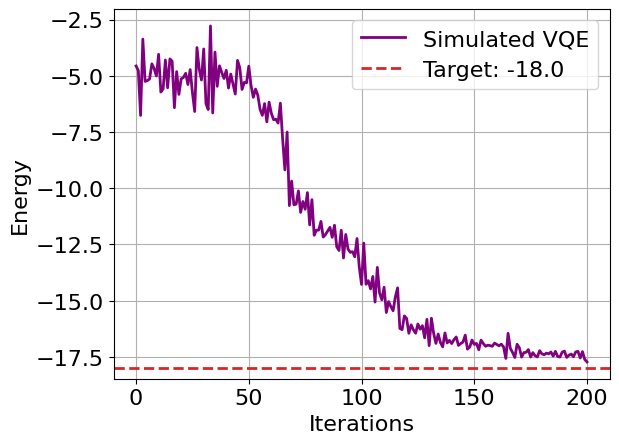

In [116]:
plt.plot(intermediate_info, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.savefig('200dpi.png', dpi=200)
plt.show()

In [23]:
def rel_err(target, measured):
    return abs((target - measured) / target)

# Compute the relative error between the expected ground state energy and the VQE's output
rel_error = rel_err(gs_energy, result.eigenvalue)

print(f'Expected ground state energy: {gs_energy:.10f}')
print(f'Computed ground state energy: {result.eigenvalue:.10f}')
print(f'Relative error: {rel_error:.8f}')

Expected ground state energy: -18.0000000000
Computed ground state energy: -6.0294902214
Relative error: 0.66502832


In [24]:
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator)
from qiskit import Aer

# Save an IBM Quantum account. See docs for credential security warning
# https://github.com/Qiskit/qiskit-ibm-runtime/tree/stable/0.7#saving-account-on-disk
# QiskitRuntimeService.save_account(channel="ibm_quantum", token="MY_IBM_QUANTUM_TOKEN")
service = QiskitRuntimeService(channel='ibm_quantum')

In [25]:
# print available backend and select one
print('Simulators:', service.backends(simulator=True))

# Select a simulator backend
backend = 'simulator_statevector'

Simulators: [<IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_statevector')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_stabilizer')>]


In [26]:
# Define a simple callback function
intermediate_info_sim_backend = []
def callback_sim(value):
        intermediate_info_sim_backend.append(value)

In [27]:
# Setup Estimator
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session)
    # Set up algorithm
    custom_vqe = CustomVQE(rt_estimator, ansatz_opt, optimizer, callback=callback_sim)
    # Run algorithm
    result = custom_vqe.compute_minimum_eigenvalue(ham_16)
end = time()
print(f'execution time (s): {end - start:.2f}')

execution time (s): 2077.39


In [ ]:
plt.plot(intermediate_info_sim_backend, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [29]:
# Compute the relative error between the expected ground state energy and the measured
rel_error = rel_err(gs_energy, result.eigenvalue)

print(f'Expected ground state energy: {gs_energy:.10f}')
print(f'Computed ground state energy: {result.eigenvalue:.10f}')
print(f'Relative error: {rel_error:.8f}')

Expected ground state energy: -18.0000000000
Computed ground state energy: -6.0890000000
Relative error: 0.66172222
